In [1]:
from bs4 import BeautifulSoup
from glob import glob
from tqdm import tqdm 
import codecs
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, chi2_kernel
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from string import punctuation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 

import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import os
import natsort
import numpy as np

stop_words = set(stopwords.words("russian"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arekusei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def dat_to_text(dat_path):
    with codecs.open(dat_path, 'r', 'utf-8') as f:
        url = f.readline().strip()
        soup = BeautifulSoup(f, 'lxml')
        title = soup.title.text
        
        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()    # rip it out

        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = ' '.join(chunk for chunk in chunks if chunk)
    return text.split()

In [3]:
def custom_tokenizer(text):

    trash = []
    for word in text:
        try:
            numb = ord(word)
            if numb >= 128:
                trash.append(word)
        except TypeError:
            continue
        
    trash = set(trash + list(stop_words))  
    tokenizer = TweetTokenizer()
    filtered_text = "".join([i for i in text if not i in punctuation]).lower().replace("\n", ' ').replace("\t", ' ').replace("\r", ' ')
    
    tokens = tokenizer.tokenize(filtered_text)
    tokens = [i for i in tokens if not i in trash and not i.startswith("https")]
    
    return tokens


In [4]:
stemmer = SnowballStemmer('russian')

def custom_stem_tokenizer(text):

  tokens = custom_tokenizer(text)
  stemmed_tokens = [stemmer.stem(w) for w in tokens]

  return stemmed_tokens

In [7]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
!python -m spacy download ru_core_news_sm

In [3]:
import spacy
nlp = spacy.load("ru_core_news_sm")

In [11]:
vocabulary = navec.vocab.words

In [198]:
def proc(text):
    text = ' '.join(text)
    text = text.replace('\n', ' ')
    text = ''.join([i for i in text if not i in punctuation + '1234567890'])
    res = []
    for i in range(len(text) // 50000 + 1):
        res += [i.lemma_.lower() for i in nlp(text[i * 50000: (i + 1) * 50000]) if not i.lemma_.lower() in stop_words and len(i.lemma_.lower()) > 1]
    return res

In [205]:
pbar = tqdm(natsort.natsorted(all_paths))
for file_path in pbar:
    
    basename = os.path.basename(file_path)
    
    # if os.path.exists(f"./texts/{basename}"):
    #     continue
    
    text = dat_to_text(file_path)
    
    if len(text) > 5000:
        factor = len(text) // 5000
        text = text[::factor][:5000]
        
    text = proc(text)
    
    embs = None
    filtered_text = []
    for x in text:
        try:
            embs = navec[x] if embs is None else np.vstack([embs, navec[x]])
            filtered_text.append(x)
        except KeyError:
            pass
    
    with codecs.open(f"./texts/{basename}", 'w', 'utf-8') as f:
        f.write(' '.join(filtered_text))
        
    np.save(f"./texts/{basename}".replace("dat", "npy"), embs)
    

  0%|          | 15/28026 [00:16<6:05:35,  1.28it/s] C:\Users\Alexey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
100%|██████████| 28026/28026 [7:37:30<00:00,  1.02it/s]   


### tfidf

In [431]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 2
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)
# if sum(y) > len(y) / 2: y = 1 - y 
titles = pd.read_csv("docs_titles.tsv", delimiter='\t', index_col=0).loc[doc_ids[ids]]
titles['y'] = y 

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

100%|██████████| 94/94 [00:00<00:00, 9887.51it/s]


In [433]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_texts, y, test_size=0.15, random_state=42, stratify=y)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(X_train)))
print(len(tfidfv.vocabulary_))

X_train = tfidfv.transform(X_train)
X_test = tfidfv.transform(X_test)

X = tfidfv.transform(all_texts)

13210


In [316]:
cv = CountVectorizer()
cv.fit(custom_stem_tokenizer(" ".join(X_train)))
print(len(cv.vocabulary_))

X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

X = cv.transform(all_texts)

8129


<Axes: xlabel='one', ylabel='two'>

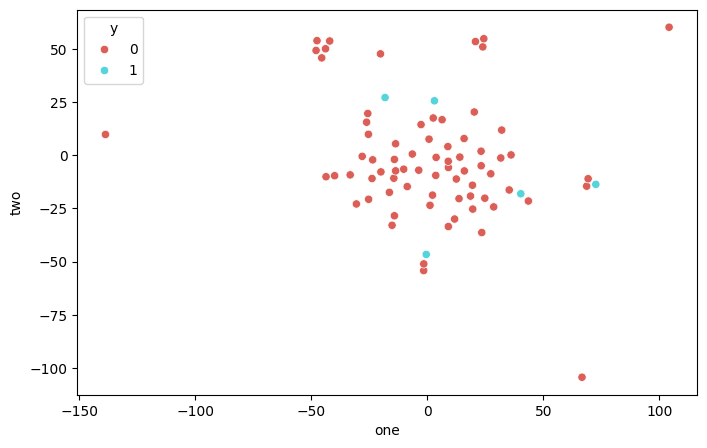

In [313]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X)
df = pd.DataFrame(X_embedded, columns=['one', 'two'])
df['y'] = y
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="one", y="two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

In [435]:
max_score = 0
best = None
pbar = tqdm(range(1, 25))
for n_popular in pbar:
    for n_top in range(1, 25):
        pbar.set_description(f"{n_top} / 25")
        for n_thresh in range(1, 10):
            popular = set(list(np.argsort(df_)[-n_popular:]))
            feature = [int(len(set(row).intersection(popular)) < n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
            score = f1_score(y_pred=feature, y_true=y)
            if score > max_score:
                max_score = score
                best = (n_popular, n_top, n_thresh)
                print(f"new record {max_score:.3f}, {best}")
            # accuracy_score(y_pred=feature, y_true=y) 

2 / 25:   0%|          | 0/24 [00:00<?, ?it/s]

new record 0.259, (1, 1, 1)


2 / 25:  42%|████▏     | 10/24 [00:36<00:51,  3.66s/it] 

new record 0.262, (11, 1, 1)
new record 0.267, (11, 2, 1)


8 / 25:  42%|████▏     | 10/24 [00:37<00:51,  3.66s/it]

new record 0.277, (11, 7, 1)
new record 0.283, (11, 8, 1)


10 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.289, (11, 9, 1)


12 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.295, (11, 11, 1)
new record 0.299, (11, 12, 1)


15 / 25:  42%|████▏     | 10/24 [00:38<00:51,  3.66s/it]

new record 0.306, (11, 14, 1)
new record 0.313, (11, 15, 1)


17 / 25:  42%|████▏     | 10/24 [00:39<00:51,  3.66s/it]

new record 0.325, (11, 16, 1)


19 / 25:  42%|████▏     | 10/24 [00:39<00:51,  3.66s/it]

new record 0.338, (11, 18, 1)
new record 0.347, (11, 19, 1)


22 / 25:  42%|████▏     | 10/24 [00:40<00:51,  3.66s/it]

new record 0.351, (11, 21, 1)


23 / 25:  50%|█████     | 12/24 [00:47<00:43,  3.65s/it]

new record 0.356, (13, 22, 1)


23 / 25:  71%|███████   | 17/24 [01:05<00:25,  3.66s/it]

new record 0.361, (18, 22, 1)


24 / 25: 100%|██████████| 24/24 [01:27<00:00,  3.66s/it]


In [102]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 47
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"a
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
X = tfidfv.transform(all_texts)
df_ = 1 / (tfidfv.idf_ + 0.1)

100%|██████████| 94/94 [00:00<00:00, 592.21it/s]


In [548]:
all_preds = []
all_confs = []
best_thresh = 0.5
for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]
    # y = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

    for file_path in doc_ids[ids]:
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.readline()
            all_texts.append(text)  
    
    mean_vector = np.asarray(X.mean(0))
    similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]
    all_confs = all_confs + similarities
    
    # best_thresh = find_threshold(np.array(similarities), y)
    feature = [int(i > best_thresh) for i in similarities]
    # score = f1_score(y_pred=feature, y_true=y)
    all_preds = all_preds + feature
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [13:57<00:00,  4.65s/it]


In [7]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

In [550]:
data = pd.DataFrame(np.vstack([pairs, all_preds]).T, columns=['pair_id', 'target'])
data.to_csv('submission_cosine_3.csv', index=False)

## pairwise metrics

In [8]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, chi2_kernel

In [171]:
all_texts = []
# all_paths = natsort.natsorted(glob("texts/*dat"))
doc_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
group_ids = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
GROUP = 118
ids = np.where(group_ids == GROUP)[0]
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3])[ids].astype(int)

for file_path in tqdm(doc_ids[ids]):
    file_path = f"texts/{file_path}.dat"
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.readline()
        all_texts.append(text)

tfidfv = TfidfVectorizer()
tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
X = tfidfv.transform(all_texts)
df_ = 1 / (tfidfv.idf_ + 0.1)

100%|██████████| 94/94 [00:00<00:00, 9999.10it/s]


In [172]:
cc = cosine_similarity(X.toarray())
cc *= (1 - np.eye(X.shape[0]))

In [179]:
cc = euclidean_distances(X.toarray())
cc += np.eye(X.shape[0]) * 10

In [180]:
idx = np.where(y)[0]
idx2 = np.where(1 -y)[0]

<Axes: ylabel='Density'>

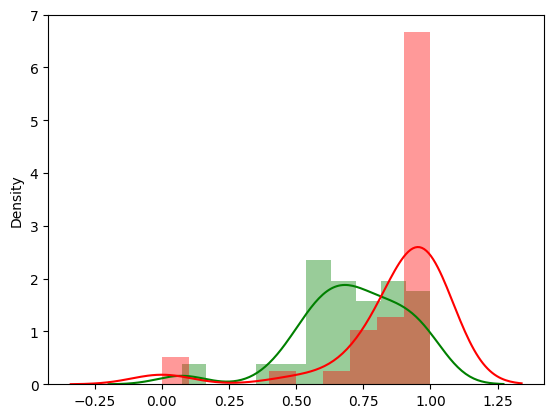

In [182]:
import warnings
warnings.filterwarnings('ignore')

hist1 = cc.min(1)[idx]
hist2 = cc.min(1)[idx2]
h1 = sns.distplot(hist1, color='green', bins=10)
sns.distplot(hist2, color='red', bins=10)


<Axes: ylabel='Density'>

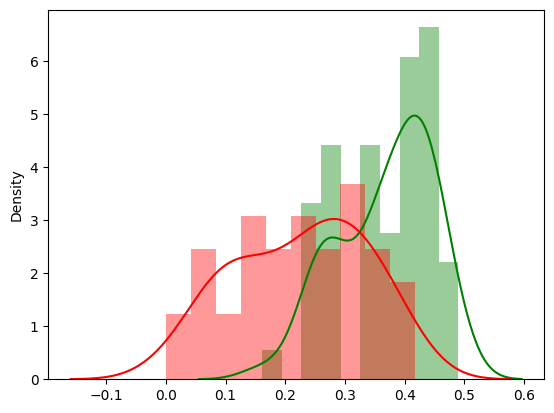

In [165]:
hist1 = cc.mean(1)[idx]
hist2 = cc.mean(1)[idx2]
sns.distplot(hist1, color='green', bins=10)
sns.distplot(hist2, color='red', bins=10)

In [136]:
all_features_1 = []
all_cosines = [] 
all_max_cosines = []
all_mean_cosines = []
all_max_chi2 = []
all_mean_chi2 = []
all_eucl = []
# titles = pd.read_csv("docs_titles.tsv", delimiter='\t', index_col=0)
titles = pd.DataFrame(np.loadtxt("docs_titles.tsv", delimiter='\t', dtype=str, encoding='utf-8')[1:], columns=["doc_id", "title"], dtype=str).set_index("doc_id")

for GROUP in tqdm(range(130, 310)):
    all_texts = []
    # all_paths = natsort.natsorted(glob("texts/*dat"))
    doc_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[2]).astype(int)
    group_ids = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
    ids = np.where(group_ids == GROUP)[0]

    for file_path in doc_ids[ids]:
        title = titles.loc[f"{file_path}"].values[0]
        file_path = f"texts/{file_path}.dat"
        with open(file_path, 'r', encoding='utf-8') as f:
            text = str(f.readline()) + str(title)
            all_texts.append(text)

    tfidfv = TfidfVectorizer()
    tfidfv.fit(custom_stem_tokenizer(" ".join(all_texts)))
    X = tfidfv.transform(all_texts)
    df_ = 1 / (tfidfv.idf_ + 0.1)

    n_thresh = 1
    n_popular = 1
    n_top = 1
    popa = set(list(np.argsort(df_)[-n_popular:]))
    feature = [int(len(set(row).intersection(popa)) < n_thresh) for row in np.argsort(X.toarray(), axis=1)[:, -n_top:]]
    all_features_1 = all_features_1 + feature
    
    mean_vector = np.asarray(X.mean(0))
    similarities = [cosine_similarity(X.getrow(i), mean_vector).item() for i in range(X.shape[0])]
    all_cosines = all_cosines + similarities
    
    sim_matrix = cosine_similarity(X.toarray())
    sim_matrix *= (1 - np.eye(X.shape[0]))
    all_max_cosines = all_max_cosines + list(sim_matrix.max(1))
    all_mean_cosines = all_mean_cosines + list(sim_matrix.mean(1))
    
    chi2_matrix = chi2_kernel(X.toarray())
    chi2_matrix *= (1 - np.eye(X.shape[0]))
    all_max_chi2 = all_max_chi2 + list(chi2_matrix.max(1))
    all_mean_chi2 = all_mean_chi2 + list(chi2_matrix.mean(1))
    
    euclidean = euclidean_distances(X.toarray())
    euclidean += np.eye(X.shape[0]) * 10
    all_eucl = all_eucl + list(euclidean.min(1))
    
    # score = f1_score(y_pred=feature, y_true=y)
    # print(f"{GROUP}: {score:.3f}")

100%|██████████| 180/180 [32:07<00:00, 10.71s/it]


In [137]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

data = pd.DataFrame(np.vstack([pairs, all_features_1]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_feature_1.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_max_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_max_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_mean_cosines]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_mean_cosines.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_max_chi2]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_max_chi2.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_mean_chi2]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_mean_chi2.csv', index=False)

data = pd.DataFrame(np.vstack([pairs, all_eucl]).T, columns=['pair_id', 'value'])
data.to_csv('features_plus_titles/test/test_eucl.csv', index=False)

In [2]:
feat_1 = np.loadtxt('features/train/train_feature_1.csv', delimiter=',', skiprows=1, usecols=[1])
feat_2 = np.loadtxt('features/train/train_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features/train/train_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features/train/train_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features/train/train_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features/train/train_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features/train/train_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

groups = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3]).astype(int)
trains = pd.DataFrame(np.vstack([groups, feat_1, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7, y]).T, 
                     columns=['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl', 'y'])

In [3]:
feat_2 = np.loadtxt('features_plus_titles/train/train_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features_plus_titles/train/train_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features_plus_titles/train/train_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features_plus_titles/train/train_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features_plus_titles/train/train_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features_plus_titles/train/train_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

groups = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
y = np.loadtxt("train_groups.csv", delimiter=',', skiprows=1, usecols=[3]).astype(int)
trains = pd.DataFrame(np.vstack([groups, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7, y]).T, 
                     columns=['groups', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl', 'y'])

In [4]:
trains

,groups,cosines,max_cosines,mean_cosines,max_chi2,mean_chi2,eucl,y
0,1.0,0.517902,0.933890,0.189952,1.172230e-01,2.658432e-03,0.363620,0.0
1,1.0,0.503264,0.853094,0.184306,5.249161e-02,2.617308e-03,0.542044,0.0
2,1.0,0.201224,0.495999,0.067809,1.037870e-02,5.848164e-04,1.003993,0.0
3,1.0,0.598809,0.776480,0.221158,5.323511e-03,4.803359e-04,0.668611,0.0
4,1.0,0.536571,0.663544,0.197153,4.603246e-03,3.680424e-04,0.820312,0.0
...,...,...,...,...,...,...,...,...
11685,129.0,0.250244,0.286817,0.077572,1.572308e-04,1.293436e-05,1.194305,0.0
11686,129.0,0.178675,0.305191,0.052244,8.232389e-08,1.057938e-08,1.178821,0.0
11687,129.0,0.457057,0.313746,0.150763,5.130281e-09,7.121415e-10,1.171540,0.0
11688,129.0,0.359957,0.607281,0.116400,1.953282e-05,2.646718e-06,0.886250,0.0


In [71]:
feat_1 = np.loadtxt('features/test/test_feature_1.csv', delimiter=',', skiprows=1, usecols=[1])
feat_2 = np.loadtxt('features/test/test_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features/test/test_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features/test/test_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features/test/test_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features/test/test_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features/test/test_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

subm_1 = (feat_2 > 0.5).astype(int)
groups = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
tests = pd.DataFrame(np.vstack([groups, feat_1, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7]).T, 
                     columns=['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl'])

In [139]:
feat_2 = np.loadtxt('features_plus_titles/test/test_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_3 = np.loadtxt('features_plus_titles/test/test_max_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_4 = np.loadtxt('features_plus_titles/test/test_mean_cosines.csv', delimiter=',', skiprows=1, usecols=[1])
feat_5 = np.loadtxt('features_plus_titles/test/test_max_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_6 = np.loadtxt('features_plus_titles/test/test_mean_chi2.csv', delimiter=',', skiprows=1, usecols=[1])
feat_7 = np.loadtxt('features_plus_titles/test/test_eucl.csv', delimiter=',', skiprows=1, usecols=[1])

subm_1 = (feat_2 > 0.5).astype(int)
groups = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[1]).astype(int)
tests = pd.DataFrame(np.vstack([groups, feat_2, feat_3, feat_4, feat_5, feat_6, feat_7]).T, 
                     columns=['groups', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'eucl'])

In [72]:
collls =  trains.columns
for col in range(1, len(collls) - 1):
    for col2 in range(col + 1, len(collls) - 1):
        name = f"{collls[col]}_by_{collls[col2]}"
        # print(name)
        column1 = collls[col]
        column2 = collls[col2]
        trains[name] = trains[column1] * trains[column2]

In [73]:
collls =  tests.columns
for col in range(1, len(collls)):
    for col2 in range(col + 1, len(collls)):
        name = f"{collls[col]}_by_{collls[col2]}"
        # print(name)
        column1 = collls[col]
        column2 = collls[col2]
        tests[name] = tests[column1] * tests[column2]

In [58]:
trains

,groups,feat_1,cosines,max_cosines,mean_cosines,max_chi2,mean_chi2,eucl,y,feat_1_by_cosines,...,max_cosines_by_mean_cosines,max_cosines_by_max_chi2,max_cosines_by_mean_chi2,max_cosines_by_eucl,mean_cosines_by_max_chi2,mean_cosines_by_mean_chi2,mean_cosines_by_eucl,max_chi2_by_mean_chi2,max_chi2_by_eucl,mean_chi2_by_eucl
0,1.0,1.0,0.521166,0.932945,0.192518,1.198959e-01,3.007209e-03,0.366209,0.0,0.521166,...,0.179609,1.118564e-01,2.805561e-03,0.341653,2.308213e-02,5.789420e-04,0.070502,3.605521e-04,4.390703e-02,1.101268e-03
1,1.0,1.0,0.505048,0.854709,0.186261,5.580970e-02,2.819831e-03,0.539057,0.0,0.505048,...,0.159199,4.770105e-02,2.410135e-03,0.460737,1.039516e-02,5.252241e-04,0.100405,1.573739e-04,3.008460e-02,1.520049e-03
2,1.0,1.0,0.201541,0.497853,0.068437,1.126110e-02,6.426828e-04,1.002145,0.0,0.201541,...,0.034071,5.606367e-03,3.199613e-04,0.498921,7.706703e-04,4.398297e-05,0.068583,7.237313e-06,1.128525e-02,6.440614e-04
3,1.0,0.0,0.596687,0.779414,0.221836,5.473449e-03,5.137912e-04,0.664208,0.0,0.000000,...,0.172902,4.266082e-03,4.004560e-04,0.517693,1.214209e-03,1.139775e-04,0.147345,2.812210e-06,3.635509e-03,3.412643e-04
4,1.0,1.0,0.537996,0.664296,0.199052,5.288895e-03,4.014840e-04,0.819395,0.0,0.537996,...,0.132229,3.513392e-03,2.667043e-04,0.544321,1.052763e-03,7.991601e-05,0.163102,2.123407e-06,4.333692e-03,3.289739e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11685,129.0,1.0,0.249314,0.286797,0.077807,1.610774e-04,1.338268e-05,1.194322,0.0,0.249314,...,0.022315,4.619651e-05,3.838112e-06,0.342528,1.253294e-05,1.041266e-06,0.092927,2.155647e-09,1.923783e-04,1.598323e-05
11686,129.0,1.0,0.178104,0.305238,0.052445,8.420643e-08,1.092573e-08,1.178781,0.0,0.178104,...,0.016008,2.570298e-08,3.334946e-09,0.359808,4.416186e-09,5.729976e-10,0.061821,9.200171e-16,9.926094e-08,1.287905e-08
11687,129.0,1.0,0.457982,0.313762,0.152126,5.946014e-09,7.660163e-10,1.171527,0.0,0.457982,...,0.047732,1.865636e-09,2.403471e-10,0.367581,9.045463e-10,1.165314e-10,0.178220,4.554744e-18,6.965915e-09,8.974086e-10
11688,129.0,1.0,0.365622,0.588345,0.119231,2.114201e-05,2.850339e-06,0.907365,0.0,0.365622,...,0.070149,1.243879e-05,1.676982e-06,0.533843,2.520790e-06,3.398498e-07,0.108186,6.026191e-11,1.918351e-05,2.586297e-06


In [63]:
from sklearn.model_selection import train_test_split

train_groups, test_groups = train_test_split(np.arange(1, 130), test_size=0.15, random_state=69)

In [64]:
trains = None
for group in train_groups:
    df_ = dataf[dataf['groups'] == group]
    trains = df_ if trains is None else pd.concat([trains, df_], axis=0)

In [65]:
tests = None
for group in test_groups:
    df_ = dataf[dataf['groups'] == group]
    tests = df_ if tests is None else pd.concat([tests, df_], axis=0)

In [140]:
X_train = trains.drop(['groups', 'y'], axis=1).values
y_train = trains['y'].values
X_test = tests.drop(['groups'], axis=1).values
# y_test = tests.iloc[:, -1].values

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [50]:
from lightgbm import LGBMClassifier

In [73]:
tree = DecisionTreeClassifier(max_depth=1)
forest = RandomForestClassifier(max_depth=7)
lr = LogisticRegression()

model = forest
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f"Train: f1_score: {f1_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, accuracy: {accuracy_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, ")
# print(f"Test: f1_score: {f1_score(y_pred=preds, y_true=y_test):.3f}, accuracy: {accuracy_score(y_pred=preds, y_true=y_test):.3f}, ")

Train: f1_score: 0.477, accuracy: 0.787, 


In [130]:
tree_1 = DecisionTreeClassifier(max_depth=5)
tree_2 = DecisionTreeClassifier(max_depth=1)
forest_1 = RandomForestClassifier(max_depth=5)


model = tree_1
model.fit(X_train, y_train)
subm_2_test = model.predict(X_test)
subm_2_train = model.predict(X_train)

model = tree_2
model.fit(X_train, y_train)
subm_3_test = model.predict(X_test)
subm_3_train = model.predict(X_train)

model = forest_1
model.fit(X_train, y_train)
subm_4_test = model.predict(X_test)
subm_4_train = model.predict(X_train)

trains['subm_1'] = (trains['feat_1'] > 0.5).astype(int)
tests['subm_1'] = (tests['feat_1'] > 0.5).astype(int)
trains['subm_2'] = subm_2_train
tests['subm_2'] = subm_2_test
trains['subm_3'] = subm_3_train
tests['subm_3'] = subm_3_test
trains['subm_4'] = subm_4_train
tests['subm_4'] = subm_4_test

trains = trains[['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'subm_1', 'subm_2', 'subm_3', 'subm_4', 'y']]
tests = tests[['groups', 'feat_1', 'cosines', 'max_cosines', 'mean_cosines', 'max_chi2', 'mean_chi2', 'subm_1', 'subm_2', 'subm_3', 'subm_4']]
X_train = trains.iloc[:, 1:-1].values
y_train = trains.iloc[:, -1].values
X_test = tests.iloc[:, 1:].values
# y_test = tests.iloc[:, -1].values

In [154]:
tree = DecisionTreeClassifier(max_depth=5)
forest = RandomForestClassifier(max_depth=5)
lr = LogisticRegression()
boosting = XGBClassifier(max_depth=5, n_estimators=11)
# boosting = LGBMClassifier(max_depth=3)

model = tree
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f"Train: f1_score: {f1_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, accuracy: {accuracy_score(y_pred=model.predict(X_train), y_true=y_train):.3f}, ")
# print(f"Test: f1_score: {f1_score(y_pred=preds, y_true=y_test):.3f}, accuracy: {accuracy_score(y_pred=preds, y_true=y_test):.3f}, ")

Train: f1_score: 0.605, accuracy: 0.796, 


In [155]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

data = pd.DataFrame(np.vstack([pairs, preds]).T, columns=['pair_id', 'target']).astype(int)
data.to_csv('submissions/0106/tree_1_titles_md1.csv', index=False)

In [156]:
preds1 = pd.read_csv("submissions/3105/boosting_6_md5_ne11_eucl.csv")
preds2 = pd.read_csv("submissions/3005/boosting_3_md5_ne10_eucl.csv")
preds3 = pd.read_csv("submissions/3005/forest_1_md5.csv")
preds4 = pd.read_csv("submissions/0106/boosting_2_titles_md5_ne11.csv")
preds5 = pd.read_csv('submissions/0106/forest_1_titles_md5_ne11.csv')
preds6 = pd.read_csv('submissions/0106/forest_2_titles_md5_ne11.csv')
preds7 = pd.read_csv('submissions/0106/tree_1_titles_md1.csv')


In [159]:
pairs = np.loadtxt("test_groups.csv", delimiter=',', skiprows=1, usecols=[0]).astype(int)

data = pd.DataFrame(np.vstack([pairs, np.clip((preds1['target'] + preds2['target'] + preds3['target'] + preds4['target'] + preds5['target'] + preds6['target']+ preds7['target']).values, 0, 1)]).T, columns=['pair_id', 'target']).astype(int)
data.to_csv('submissions/0106/best_sum_titles_3.csv', index=False)